## Installations

In [ ]:
!sudo apt-get install -y xvfb ffmpeg x11-utils
# !pip install -q 'gym==0.10.11'
!pip install gym[box2d] 
!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'
!pip install -q pyvirtualdisplay
!pip install -q tf-agents
!pip install plotly==4.8

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 994 kB in 1s (1,296 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 3.)
debconf: falling back t

In [ ]:
!pip install colabgymrender

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filepath = r"drive/My Drive/Colab Notebooks/ReinforcementLearning/lunar_lander_continuous_DDQN/"

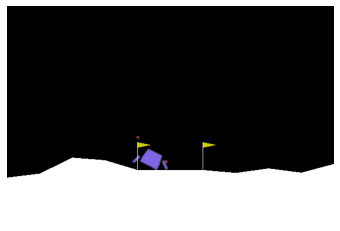

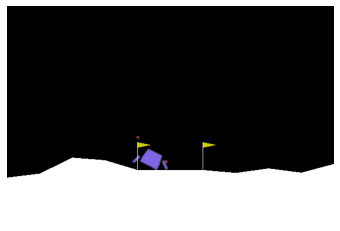

In [ ]:
import gym
from IPython import display
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
import time
from colabgymrender.recorder import Recorder
import numpy as np
from gym.spaces import Discrete
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import pandas as pd
import plotly.express as px 
from datetime import datetime

d = Display()
d.start()

game_name = 'LunarLanderContinuous-v2'
env = gym.make(game_name)
directory = './video'

env = Recorder(env, directory, fps = 3)
state = env.reset()
img = plt.imshow(env.render('rgb_array'))
episode = 0
while episode < 2:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    display.clear_output(wait=True)
    img.set_data(env.render('rgb_array'))
    plt.axis('off')
    display.display(plt.gcf())
    if done:
      episode += 1
      env.reset()


In [ ]:
print(f"action space: {env.action_space}")
print(f"observation space: {env.observation_space}")

action space: Box(-1.0, 1.0, (2,), float32)
observation space: Box(-inf, inf, (8,), float32)


In [ ]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential([
                Dense(fc1_dims, input_shape=(input_dims,)),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(n_actions)])

    model.compile(optimizer=Adam(lr=lr), loss='mse')

    return model

class DDQNAgent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=1000000, fname='ddqn_model.h5', replace_target=100):
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.replace_target = replace_target
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions,
                                   discrete=True)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)
        self.q_target = build_dqn(alpha, n_actions, input_dims, 256, 256)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def learn(self):
        if self.memory.mem_cntr > self.batch_size:
            state, action, reward, new_state, done = \
                                          self.memory.sample_buffer(self.batch_size)

            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action, action_values)

            q_next = self.q_target.predict(new_state)
            q_eval = self.q_eval.predict(new_state)
            q_pred = self.q_eval.predict(state)

            max_actions = np.argmax(q_eval, axis=1)

            q_target = q_pred

            batch_index = np.arange(self.batch_size, dtype=np.int32)

            q_target[batch_index, action_indices] = reward + \
                    self.gamma*q_next[batch_index, max_actions.astype(int)]*done

            _ = self.q_eval.fit(state, q_target, verbose=0)

            self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                           self.epsilon_min else self.epsilon_min
            if self.memory.mem_cntr % self.replace_target == 0:
                self.update_network_parameters()

    def update_network_parameters(self):
        self.q_target.set_weights(self.q_eval.get_weights())

    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval = load_model(self.model_file)
        if self.epsilon == 0.0:
            self.update_network_parameters()

In [ ]:
main_engine_values = np.linspace(-1, 1, 3)
side_engine_values = np.linspace(-1, 1, 3)
mesh = np.array(np.meshgrid(main_engine_values, side_engine_values))
action_combos = mesh.T.reshape(-1,2)
print("Possible actions:")
action_combos

Possible actions:


array([[-1., -1.],
       [-1.,  0.],
       [-1.,  1.],
       [ 0., -1.],
       [ 0.,  0.],
       [ 0.,  1.],
       [ 1., -1.],
       [ 1.,  0.],
       [ 1.,  1.]])

Total of 9 different actions - more than 2X than the discrete version (4 actions)

In [ ]:
# hyper parameters
import random
gamma = 0.99
lr = 0.001
epsilon = 0.1
n_games = 100
# seeds = [1, 10, 42, 100, 144]
seeds = [100, 144]

# change to discrete env - 9 possible actions
timestamp_str = datetime.now().strftime("%d-%b-%Y %H-%M")
num_continuous_actions = 3
main_engine_values = np.linspace(-1, 1, num_continuous_actions)
side_engine_values = np.linspace(-1, 1, num_continuous_actions)
mesh = np.array(np.meshgrid(main_engine_values, side_engine_values))
action_combos = mesh.T.reshape(-1,2)
print(f"Possible actions: \n {action_combos}")
results_df = pd.DataFrame()
hyper_params_combos = []

for seed in seeds:
  random.seed(seed)       
  env = gym.make('LunarLanderContinuous-v2')
  env.action_space = Discrete(len(action_combos))

  hyper_params_combo = f"seed_{seed}"
  hyper_params_combos.append(hyper_params_combo)
  print(f"\n Start training with the following hyper params")
  print(f"{hyper_params_combo}")

  agent = DDQNAgent(gamma=gamma, epsilon=epsilon, alpha=lr, input_dims=8,
            n_actions=env.action_space.n, mem_size=1000000, 
            batch_size=64, epsilon_end=0.0, fname = filepath + hyper_params_combo + "_ddqn.h5")
  scores = []
  eps_history = []

  for i in range(n_games):
      done = False
      score = 0
      observation = env.reset()
      while not done:
          action = agent.choose_action(observation)
          # print(action)
          continuous_action = action_combos[action]
          observation_, reward, done, info = env.step(continuous_action)
          score += reward
          agent.remember(observation, action, reward, observation_, int(done))
          observation = observation_
          agent.learn()

      eps_history.append(agent.epsilon)
      scores.append(score)

      avg_score = np.mean(scores[max(0, i-100):(i+1)])
      print('episode: ', i,'score: %.2f' % score,
            ' average score %.2f' % avg_score)
      
      if i % 10 == 0 and i > 0:
          agent.save_model()

      # results_df = pd.DataFrame({hyper_params_combo: scores})
      # results_df.to_csv(filepath + f"{timestamp_str}_result_df_ddqn.csv", index=False)
  results_df[hyper_params_combo] = scores
  # save results df
  results_df.to_csv(filepath + f"{timestamp_str}_result_df_ddqn.csv", index=False)


Possible actions: 
 [[-1. -1.]
 [-1.  0.]
 [-1.  1.]
 [ 0. -1.]
 [ 0.  0.]
 [ 0.  1.]
 [ 1. -1.]
 [ 1.  0.]
 [ 1.  1.]]

 Start training with the following hyper params
seed_100
episode:  0 score: -559.84  average score -559.84
episode:  1 score: -242.76  average score -401.30
episode:  2 score: -129.04  average score -310.55
episode:  3 score: -279.73  average score -302.84
episode:  4 score: -145.27  average score -271.33
episode:  5 score: -203.30  average score -259.99
episode:  6 score: -398.16  average score -279.73
episode:  7 score: -178.94  average score -267.13
episode:  8 score: -173.38  average score -256.71
episode:  9 score: -206.84  average score -251.73
episode:  10 score: -221.17  average score -248.95
episode:  11 score: -136.50  average score -239.58
episode:  12 score: -98.26  average score -228.71
episode:  13 score: -172.81  average score -224.71
episode:  14 score: 15.47  average score -208.70
episode:  15 score: -126.16  average score -203.54
episode:  16 score:

In [ ]:
results_df

,seed_1,seed_10,seed_42,seed_100,seed_144
0,-283.485350,-670.987334,-541.289879,-559.837694,-628.428317
1,-133.614233,-337.224256,-370.481667,-242.758564,-293.296185
2,-195.010389,-109.527365,-141.819271,-129.044633,-398.381258
3,-277.951846,-179.547344,-348.717876,-279.733992,-91.566629
4,-312.745736,-90.173904,-629.299589,-145.269204,-154.877383
...,...,...,...,...,...
95,-173.705577,-144.761370,12.545753,233.498058,246.981416
96,-134.402940,-197.181095,-72.539201,-189.919090,167.240346
97,-8.219416,-207.814042,-98.294441,267.547795,279.858423
98,-61.528884,-13.024597,-58.185589,250.779262,227.382601


In [ ]:
fig = px.line(results_df, x=np.arange(results_df.shape[0]), y=results_df.columns)
fig.update_layout(
    yaxis_title="Score",
    xaxis_title="Iteration",
    title = "Learning Comparison Between Different Hyper Parameters"
)
fig.show()

## Running after finishing Trainng phase

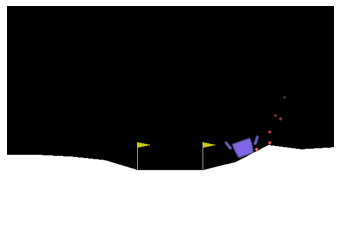

score= -434.1980825889578


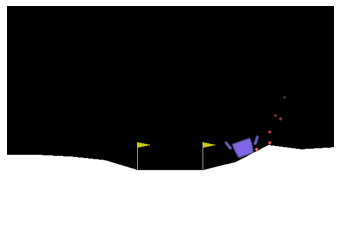

In [ ]:
from IPython import display as ipythondisplay
observation = env.reset()
print(state)
img = plt.imshow(env.render('rgb_array'))
score = 0
done = False
step_num = 0
while not done:
     action = agent.choose_action(observation)
     continuous_action = action_combos[action]
     observation_, reward, done, info = env.step(continuous_action)
     score += reward

     display.clear_output(wait=True)
     img.set_data(env.render('rgb_array'))
     plt.axis('off')
     display.display(plt.gcf())
print("score=", score)


Based on https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/DeepQLearning/simple_dqn_keras.py